# Крок 1: Імпорт необхідних бібліотек
# На цьому кроці ми імпортуємо всі необхідні бібліотеки. Крім того, з метою візуалізації результатів ми будемо використовувати torchvision.utils

# Крок 2: Завантаження набору даних MNIST
# На цьому кроці ми будемо використовувати набір даних MNIST з використанням класу DataLoader бібліотеки torch.utils.data для завантаження наших навчальних і тестових наборів даних.

In [1]:
import numpy as np
import torch
import torch.utils.data
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.autograd import Variable
from torchvision import datasets, transforms
from torchvision.utils import make_grid , save_image
%matplotlib inline
import matplotlib.pyplot as plt


batch_size = 64
train_loader = torch.utils.data.DataLoader(
datasets.MNIST('./data',
    train=True,
    download = True,
    transform = transforms.Compose(
        [transforms.ToTensor()])
     ),
     batch_size=batch_size
)

test_loader = torch.utils.data.DataLoader(
datasets.MNIST('./data',
    train=False,
    transform=transforms.Compose(
    [transforms.ToTensor()])
    ),
    batch_size=batch_size)

# Крок 3: Визначення моделі
# На цьому кроці ми почнемо будувати нашу модель. Визначимо перетворення, пов'язані з видимими і прихованими нейронами. Крім того, оскільки машина Больцмана є енергетичною моделлю, ми також визначаємо енергетичну функцію для обчислення різниці енергій. У функції ініціалізації ми також ініціалізуємо ваги та зміщення для прихованих та видимих нейронів.

In [2]:

class RBM(nn.Module):
   def __init__(self,
               n_vis=784,
               n_hin=500,
               k=5):
        super(RBM, self).__init__()
        self.W = nn.Parameter(torch.randn(n_hin,n_vis)*1e-2)
        self.v_bias = nn.Parameter(torch.zeros(n_vis))
        self.h_bias = nn.Parameter(torch.zeros(n_hin))
        self.k = k
    
   def sample_from_p(self,p):
       return F.relu(torch.sign(p - Variable(torch.rand(p.size()))))
    
   def v_to_h(self,v):
        p_h = F.sigmoid(F.linear(v,self.W,self.h_bias))
        sample_h = self.sample_from_p(p_h)
        return p_h,sample_h
    
   def h_to_v(self,h):
        p_v = F.sigmoid(F.linear(h,self.W.t(),self.v_bias))
        sample_v = self.sample_from_p(p_v)
        return p_v,sample_v
        
   def forward(self,v):
        pre_h1,h1 = self.v_to_h(v)
        
        h_ = h1
        for _ in range(self.k):
            pre_v_,v_ = self.h_to_v(h_)
            pre_h_,h_ = self.v_to_h(v_)
        
        return v,v_
    
   def free_energy(self,v):
        vbias_term = v.mv(self.v_bias)
        wx_b = F.linear(v,self.W,self.h_bias)
        hidden_term = wx_b.exp().add(1).log().sum(1)
        return (-hidden_term - vbias_term).mean()



# Крок 4: Ініціалізація та навчання моделі
# Клас RBM ініціалізується k як 1. У цьому прикладі ми будемо використовувати оптимізатор SGD. В кінці процесу ми акумулюємо всі втрати в 1D масиві, для якого спочатку ініціалізуємо масив. Витягнемо розподіл Бернуллі за допомогою методу. Це шаблон введення, над яким ми почнемо працювати.data.bernoulli()

# Далі згенерований шаблон подається до об'єкта моделі rbm. Модель повертає шаблон, за яким вона була подана, і обчислений шаблон як вихід. Втрати обчислюються як різниця між енергіями в цих двох моделях і додаються до списку. Як вже говорилося раніше, так як оптимізатор виконує адитивні дії, ми спочатку ініціалізуємо акумулятори в нуль. Втрата розмножується назад за допомогою методу. Виконує оновлення параметра на основі поточного градієнта (накопиченого та збереженого в атрибуті параметра під час виклику) та правила оновлення.backward()optimizer.step().gradbackward()



In [4]:


rbm = RBM(k=1)
train_op = optim.SGD(rbm.parameters(),0.1)

for epoch in range(5):
    loss_ = []
    for _, (data,target) in enumerate(train_loader):
        data = Variable(data.view(-1,784))
        sample_data = data.bernoulli()
        
        v,v1 = rbm(sample_data)
        loss = rbm.free_energy(v) - rbm.free_energy(v1)
        loss_.append(loss.data)
        train_op.zero_grad()
        loss.backward()
        train_op.step()

    print("Training loss for {} epoch: {}".format(epoch, np.mean(loss_)))
    
    
   

Training loss for 0 epoch: -8.386109352111816
Training loss for 1 epoch: -6.626692771911621
Training loss for 2 epoch: -4.611507892608643
Training loss for 3 epoch: -3.163212776184082
Training loss for 4 epoch: -2.212916612625122


# У наведеному нижче фрагменті коду ми визначили допоміжну функцію, в якій ми транспонуємо зображення numpy у відповідні розміри та зберігаємо його в локальному сховищі з ім'ям, переданим як вхідні дані функції.

In [5]:

def show_adn_save(file_name,img):
    npimg = np.transpose(img.numpy(),(1,2,0))
    f = "./%s.png" % file_name
    plt.imshow(npimg)
    plt.imsave(f,npimg)


# Крок 5: Візуалізація виходів

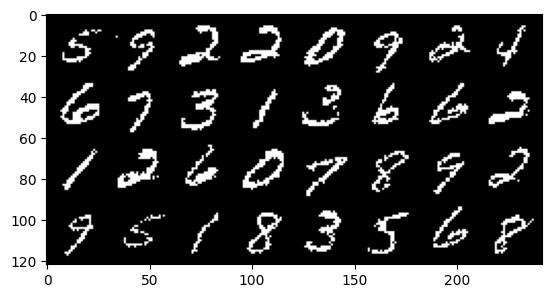

In [6]:

show_adn_save("real",make_grid(v.view(32,1,28,28).data))


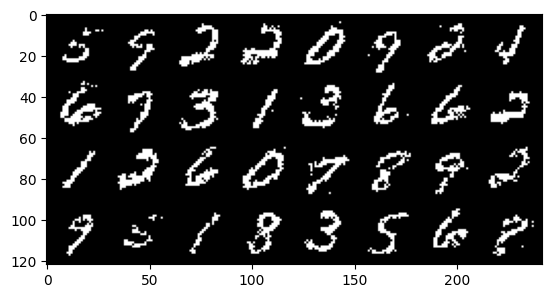

In [7]:

show_adn_save("generate",make_grid(v1.view(32,1,28,28).data))

# Як ми бачимо, зверху у нас є реальне зображення з набору даних MNIST, а нижче зображення, згенероване машиною Больцмана.